In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList, SkopeRules, IRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple'
os.makedirs(MODELS_DIR, exist_ok=True)


# set up data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
X_train, y_train = X[train_idxs][:half], y[train_idxs][:half]
X_cv, y_cv = X[train_idxs][half:], y[train_idxs][half:]
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]
X_test2, y_test2 = X[test_idxs2], y[test_idxs2]


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_test1, X_test2, X_cv], [y_test1, y_test2, y_cv], ['_test1', '_test2', '_cv']):
        sens, spec, threshes = validate.sensitivity_specificity_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_cv')
        results['sens' + suffix] = sens
        results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return sens, spec, threshes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# fit simple models

**decision tree**

100%|██████████| 8/8 [00:00<00:00, 142.77it/s]


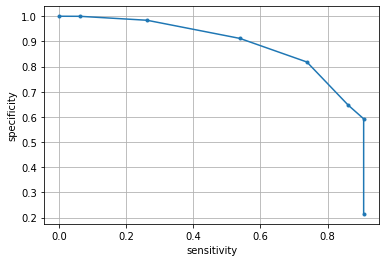

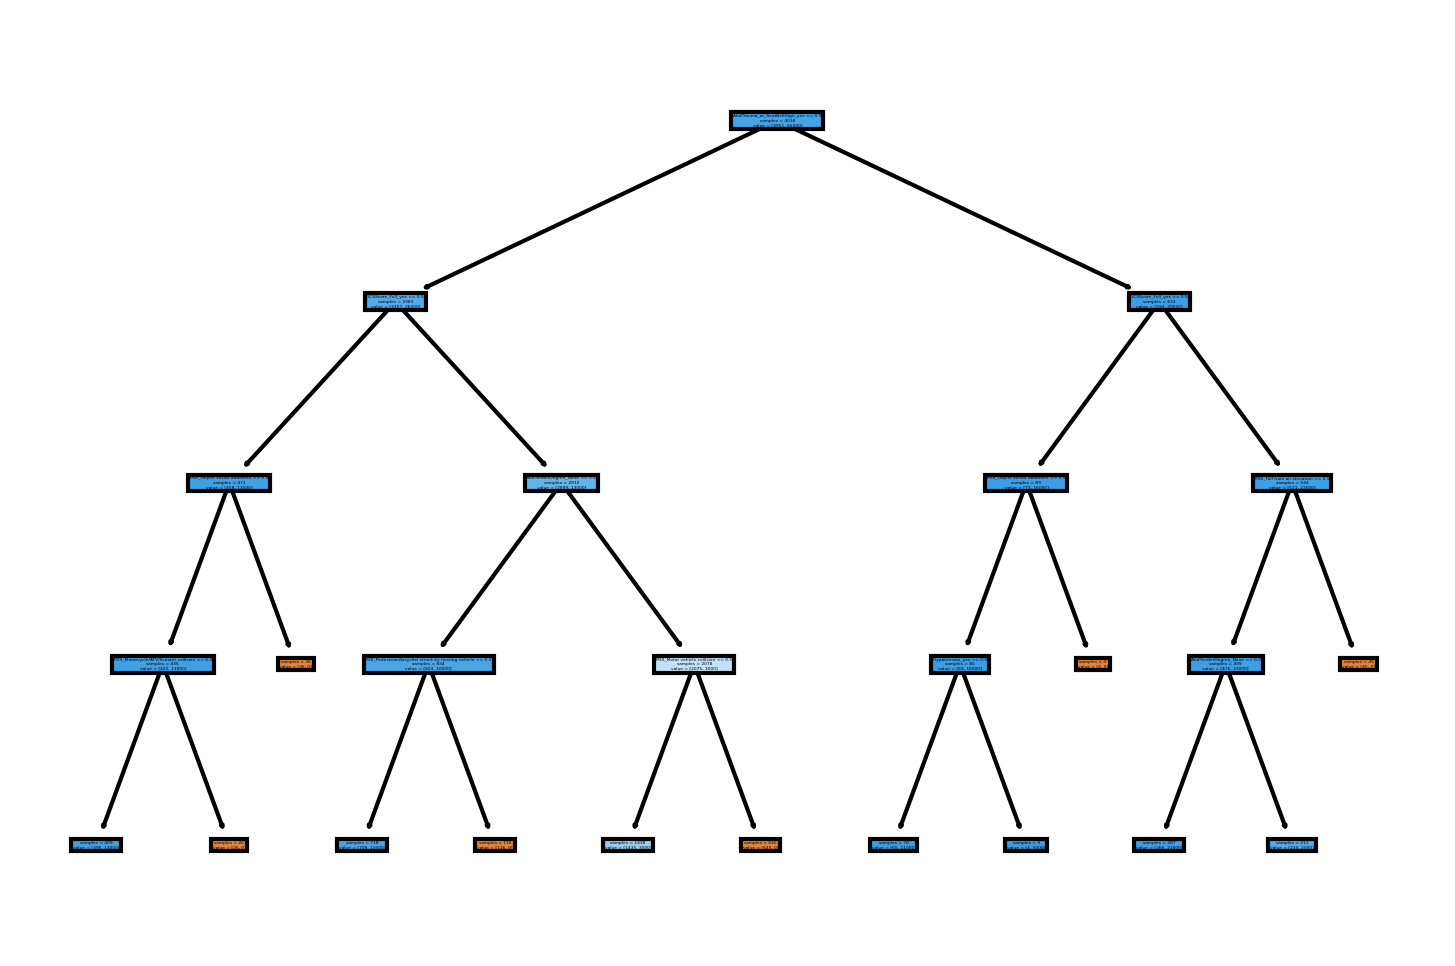

In [77]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(dt, model_name='decision_tree')

# visualize
plt.figure(dpi=300)
plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule lists**

training bayesian_rule_list...


100%|██████████| 5/5 [00:00<00:00, 144.60it/s]


Trained RuleListClassifier for detecting IwI
IF AbdTenderDegree_None : 0.5_to_inf AND GCSScore_Full_yes : 0.5_to_inf THEN probability of IwI: 0.3% (0.1%-0.5%)
ELSE IF Hypotension_yes : 0.5_to_inf THEN probability of IwI: 22.0% (11.8%-34.3%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : 0.5_to_inf THEN probability of IwI: 8.3% (5.8%-11.2%)
ELSE IF DecrBreathSound_yes : -inf_to_0.5 THEN probability of IwI: 1.1% (0.6%-1.7%)
ELSE probability of IwI: 20.5% (9.6%-34.3%)



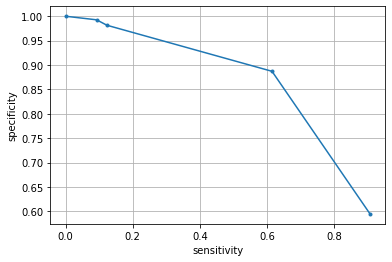

In [78]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

**rulefit**

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007484362931979405, tolerance: 0.004327680239073583
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013744752548685568, tolerance: 0.004327680239073583
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010550152961368298, tolerance: 0.004327680239073583
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_

                                                  rule    type      coef  \
1                                 AbdTenderDegree_None  linear -0.005207   
776  DecrBreathSound_yes <= 0.5 & Hypotension_yes <...    rule -0.009637   
81   Hypotension_yes <= 0.5 & AbdDistention_or_Abdo...    rule -0.001203   
742  MOI_Motorcycle/ATV/Scooter collision <= 0.5 & ...    rule -0.002303   
741  Hypotension_yes <= 0.5 & MOI_Bike collision/fa...    rule -0.012566   
637  VomitWretch_yes <= 0.5 & AbdDistention_or_Abdo...    rule -0.001276   
40   DecrBreathSound_yes <= 0.5 & GCSScore_Full_yes...    rule -0.025860   
185  DecrBreathSound_yes <= 0.5 & AbdTrauma_or_Seat...    rule -0.001269   
78   Hypotension_yes <= 0.5 & AbdTrauma_or_SeatBelt...    rule -0.011661   
801  MOI_Motorcycle/ATV/Scooter collision <= 0.5 & ...    rule -0.002229   
765  ThoracicTrauma_yes <= 0.5 & AbdTrauma_or_SeatB...    rule -0.000357   
153                         AbdTenderDegree_None > 0.5    rule -0.004676   
377  Hypoten

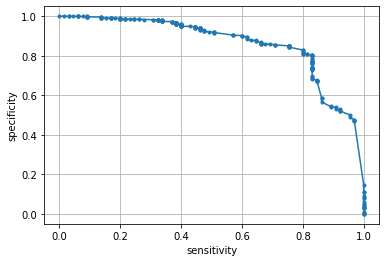

In [79]:
# fit a rulefit model
np.random.seed(13)
rulefit = RuleFit()
rulefit.fit(X_train, y_train, feature_names=processed_feats)

# preds = rulefit.predict(X_test)
sens, spec, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''
# print(sklearn.metrics.classification_report(y_test, preds))
rules = rulefit.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
print(rules)

**slim**

In [81]:
fewest_feats = data.fewest_feats
CLASS_WEIGHT = 100
n = X_train.shape[0]
lambda_reg = 10

# optionally upweight positive samples
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
X_train_small = X_train[fewest_feats]
slim = SLIM()
slim.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=lambda_reg,
      sample_weight=sample_weight)

# calculate mse on the training data
# sens, spec, threshes = predict_and_save(slim, model_name='slim')

X_test_small = X_test1[fewest_feats]
# preds = slim.predict(X_test_small)
# preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
preds_proba = slim.predict_proba(X_test_small)
print('considered ', len(fewest_feats), 'feats')
coefs = slim.model.coef_.astype(int)
intercept = slim.model.intercept_
for i in range(len(fewest_feats)):
    if coefs[i] != 0:
        print(fewest_feats[i], coefs[i])
print('intercept', intercept)

considered  10 feats
AbdTenderDegree_None 57
AbdTrauma_or_SeatBeltSign_yes 18
CostalTender_yes 16
DecrBreathSound_yes 1
GCSScore_Full_yes 48
MOI_Fall from an elevation 33
MOI_Motor vehicle collision 24
MOI_Motorcycle/ATV/Scooter collision 12
ThoracicTrauma_yes 10
VomitWretch_yes 26
intercept 0


100%|██████████| 11/11 [00:00<00:00, 148.25it/s]


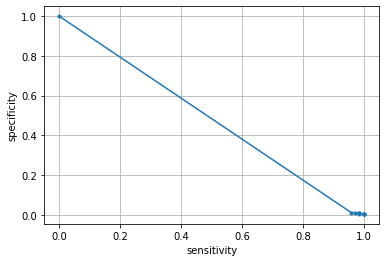

In [82]:
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test1, preds_proba[:, 1], plot=True)

**skope rules**

  0%|          | 0/18 [00:00<?, ?it/s]

Rules for iai
('AbdTenderDegree_None <= 0.5 and VomitWretch_yes > 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3259347305208719, 0.18587486871388298, 25))
('ThoracicTrauma_yes > 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.7130952380952381, 0.11067641570416265, 5))
('VomitWretch_yes > 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5 and DecrBreathSound_yes <= 0.5', (0.19635229391613823, 0.17735668127417203, 25))
('AbdTrauma_or_SeatBeltSign_yes > 0.5 and DecrBreathSound_yes <= 0.5 and GCSScore_Full_yes <= 0.5', (0.16436011755573218, 0.206168440530279, 18))
('ThoracicTrauma_yes > 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5 and Hypotension_yes > 0.5', (0.6696428571428572, 0.10310374149659865, 2))
('AbdTrauma_or_SeatBeltSign_yes > 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.5902777777777778, 0.10319148936170214, 2))
('MOI_Motor vehicle collision > 0.5 and ThoracicTrauma_yes > 0.5 and DecrBreathSound_yes > 0.5', (0.4782116032116032, 0.1062458952362997, 

100%|██████████| 20/20 [00:00<00:00, 145.13it/s]


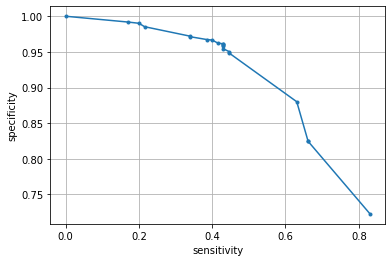

In [83]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=100,
                 n_estimators=100,
                 precision_min=0.01, # per rule precision min
                 recall_min=0.1,     # per rule recall min
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
sens, spec, threshes = predict_and_save(clf, model_name='skope')

plt.show()

**greedy rule list**

In [84]:
class_weight = {0: 1, 1: 1}
d = GreedyRuleList(max_depth=7, class_weight=class_weight, criterion='gini')
d.fit(X_train, y_train, verbose=True)

mean 1.619
mean 0.769
mean 0.542
mean 0.427
mean 0.281
mean 0.098
mean 0.052


[{'col': 'AbdTrauma_or_SeatBeltSign_yes',
  'index_col': 2,
  'cutoff': 1,
  'val': 0.016185258964143426,
  'flip': False,
  'val_right': 0.061611374407582936,
  'num_pts': 4016,
  'num_pts_right': 633},
 {'col': 'DecrBreathSound_yes',
  'index_col': 5,
  'cutoff': 1,
  'val': 0.007685486254803429,
  'flip': False,
  'val_right': 0.12307692307692308,
  'num_pts': 3383,
  'num_pts_right': 65},
 {'col': 'Hypotension_yes',
  'index_col': 7,
  'cutoff': 1,
  'val': 0.0054249547920434,
  'flip': False,
  'val_right': 0.09523809523809523,
  'num_pts': 3318,
  'num_pts_right': 42},
 {'col': 'GCSScore_Full_yes',
  'index_col': 6,
  'cutoff': 1,
  'val': 0.004273504273504274,
  'flip': True,
  'val_right': 0.014150943396226415,
  'num_pts': 3276,
  'num_pts_right': 424},
 {'col': 'AbdTenderDegree_None',
  'index_col': 1,
  'cutoff': 1,
  'val': 0.002805049088359046,
  'flip': True,
  'val_right': 0.007398273736128237,
  'num_pts': 2852,
  'num_pts_right': 811},
 {'col': 'MOI_Motorcycle/ATV/Scoo

100%|██████████| 8/8 [00:00<00:00, 146.31it/s]


	                                    => 1.62% risk (4016 pts)
           if AbdTrauma_or_SeatBeltSign_yes ===> 6.2% risk (633 pts)
	                                    => 0.77% risk (3383 pts)
                     if DecrBreathSound_yes ===> 12.3% risk (65 pts)
	                                    => 0.54% risk (3318 pts)
                         if Hypotension_yes ===> 9.5% risk (42 pts)
	                                    => 0.43% risk (3276 pts)
                      if ~GCSScore_Full_yes ===> 1.4% risk (424 pts)
	                                    => 0.28% risk (2852 pts)
                   if ~AbdTenderDegree_None ===> 0.7% risk (811 pts)
	                                    => 0.1% risk (2041 pts)
    if MOI_Motorcycle/ATV/Scooter collision ===> 0.9% risk (112 pts)
	                                    => 0.05% risk (1929 pts)
                      if ThoracicTrauma_yes ===> 0.4% risk (244 pts)
	                                    => 0% risk (1685 pts)



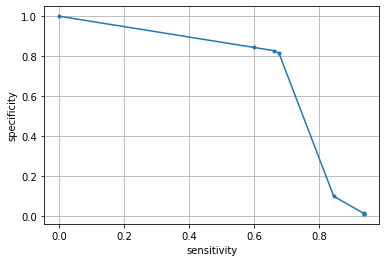

In [85]:
sens, spec, threshes = predict_and_save(d, model_name='grl')
d.print_list()

100%|██████████| 8/8 [00:00<00:00, 144.71it/s]


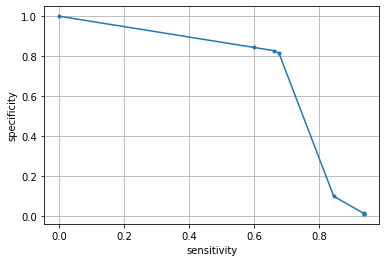

In [86]:
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(d, model_name='grl')
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [87]:
imps = irf.model.feature_importances_.round(3) * 100
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

MOI_Motorcycle/ATV/Scooter collision 2.9000000000000004
AbdDistention_or_AbdomenPain_yes 3.6999999999999997
MOI_Bike collision/fall 3.6999999999999997
MOI_Fall from an elevation 3.8
Age<2_yes 4.3
MOI_Pedestrian/bicyclist struck by moving vehicle 4.5
MOI_Object struck abdomen 4.6
MOI_Motor vehicle collision 6.9
CostalTender_yes 7.1
DecrBreathSound_yes 7.3999999999999995
AbdTenderDegree_None 7.5
Hypotension_yes 7.9
AbdTrauma_or_SeatBeltSign_yes 8.1
GCSScore_Full_yes 8.3
VomitWretch_yes 8.799999999999999
ThoracicTrauma_yes 10.6


# look at all the results

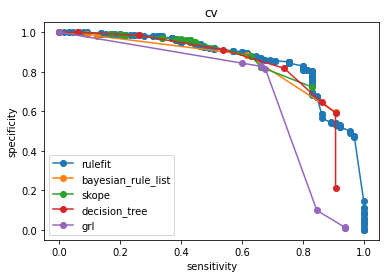

In [88]:
suffix = '_cv' # _test1, _test2, _cv
for fname in os.listdir(MODELS_DIR):
    if 'pkl' in fname:
        r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
#         print(r)
        sens = r['sens' + suffix]
        spec = r['spec' + suffix]
        plt.plot(sens, spec, 'o-', label=fname[:-4])
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.title(suffix[1:])
plt.legend()